In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time;  from datetime import datetime
import math
plt.rcParams["figure.figsize"] = (15,10)

In [3]:
mobile = pd.read_csv('mobile_bid_adjustments.csv') # read the mobile
# date range -> "June 1, 2017 - January 26, 2018"

summary = mobile.tail(2) # store summary rows separately
mobile = mobile.drop([327,328]) # drop summary columns rows
orig_mobile=pd.read_csv('mobile_bid_adjustments.csv') # read the mobile

In [4]:
mobile.rename(columns={'Avg. CPC':'avg_cpc($)'}, inplace=True)
mobile.rename(columns={'Cost / conv.':'cost_per_conv($)'}, inplace=True)
mobile.rename(columns={'Conv. rate':'conversion_rate(%)'}, inplace=True)
mobile.rename(columns={'Avg. CPC':'avg_cpc($)'}, inplace=True)
mobile.rename(columns={'Cost':'Cost($)'}, inplace=True)
mobile.rename(columns={'CTR':'CTR(%)'}, inplace=True)
mobile.rename(columns={'Conv. value':'Conv. value($)'}, inplace=True)
mobile.rename(columns={'Bid adj.':"Bid adj.(%)"}, inplace=True)

In [5]:
mobile.head()

,Location,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost
0,"Fremont, Ohio, United States",+60%,72,"1,108",6.50%,$0.43,$30.82,2.6,0.00,$0.00,0.00%,0.00,0.00
1,"32216, Florida, United States",+45%,51,857,5.95%,$0.43,$22.04,2.6,0.00,$0.00,0.00%,0.00,0.00
2,"Madera, California, United States",+60%,186,"2,187",8.50%,$0.46,$85.09,2.6,2.00,$42.55,1.08%,103.30,1.21
3,"Linden, Alabama, United States",+60%,3,79,3.80%,$0.31,$0.93,3.0,0.00,$0.00,0.00%,0.00,0.00
4,"60632, Illinois, United States",-90%,8,263,3.04%,$0.02,$0.19,3.7,0.00,$0.00,0.00%,0.00,0.00


In [6]:
### CONVERT DATA INTO FLOATS FOR GRAPHING


# convert dollar amounts into floats for processing

def convert_dollar_float(row):
    try:
        return float(str(row)[1:])
    except:
        return float(str(row)[1:].replace(',', ''))
    
mobile['Cost($)'] = mobile['Cost($)'].apply(convert_dollar_float)
mobile['avg_cpc($)'] = mobile['avg_cpc($)'].apply(convert_dollar_float)
mobile['cost_per_conv($)'] = mobile['cost_per_conv($)'].apply(convert_dollar_float)

# convert percentages into floats for processing

def convert_percentage_float(row):
    try:
        return float(str(row)[:-1])
    except:
        return np.NaN
mobile['conversion_rate(%)'] =mobile['conversion_rate(%)'].apply(convert_percentage_float)    
mobile['CTR(%)'] = mobile['CTR(%)'].apply(convert_percentage_float)    
mobile['Bid adj.(%)']=mobile['Bid adj.(%)'].apply(convert_percentage_float)

# convert strings with commas into floats

def change_comma_values_to_float(row):
    row = str(row).replace(',', '')
    return float(row)

def change_str_float(row):
    try:
        row = str(row).replace(',', '')
        return float(row)
    except:
        return np.NaN
    
mobile.Conversions=mobile.Conversions.apply(change_comma_values_to_float)
mobile['Conv. value($)']=mobile['Conv. value($)'].apply(change_comma_values_to_float)
mobile['Avg. pos.']=mobile['Avg. pos.'].apply(change_str_float)
mobile['Clicks']=mobile['Clicks'].apply(change_str_float)
mobile['Impr.']=mobile['Impr.'].apply(change_str_float)


# convert bid adjustment to float
def strip_first_last(row):
    try:
        row  = (str(row)[1:-1])
        return float(row)
    except:
        return 0



In [7]:
mobile.describe()

,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost
count,493.000000,495.000000,4.950000e+02,495.000000,495.000000,495.000000,490.000000,495.000000,495.000000,495.000000,4.950000e+02,495.000000
mean,19.835700,4807.721212,7.023261e+04,6.716667,0.345434,1620.025596,2.826531,85.816162,18.256384,1.666444,7.222667e+03,5.051051
std,44.910835,50555.028390,7.383695e+05,1.815583,0.131202,17041.622506,0.323374,902.723163,23.044575,2.242880,7.600081e+04,17.835417
min,-90.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.900000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,-15.000000,79.500000,1.178500e+03,5.900000,0.280000,27.300000,2.600000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,36.000000,196.000000,2.987000e+03,7.010000,0.380000,71.760000,2.700000,3.000000,15.400000,1.300000,2.109400e+02,2.580000
75%,60.000000,633.000000,9.158000e+03,7.825000,0.450000,237.495000,3.000000,12.000000,25.065000,2.010000,1.078525e+03,5.020000
max,60.000000,796336.000000,1.162856e+07,16.190000,0.590000,268700.010000,3.900000,14209.000000,304.750000,26.920000,1.196464e+06,362.820000


In [8]:
### Extract State and city/zip data from Location

# Extract state from location data
def state_from_location(row):
    try:
        row = str(row).split(',')
        return row[-2].strip()
    except:
        return np.nan
mobile['state'] = mobile.Location.apply(state_from_location)

# Extract city or zip from location data
def cityzip_from_location(row):
    try:
        row = str(row).split(',')
        return row[-3].strip()
    except:
        return np.nan
mobile['cityzip'] = mobile.Location.apply(cityzip_from_location)


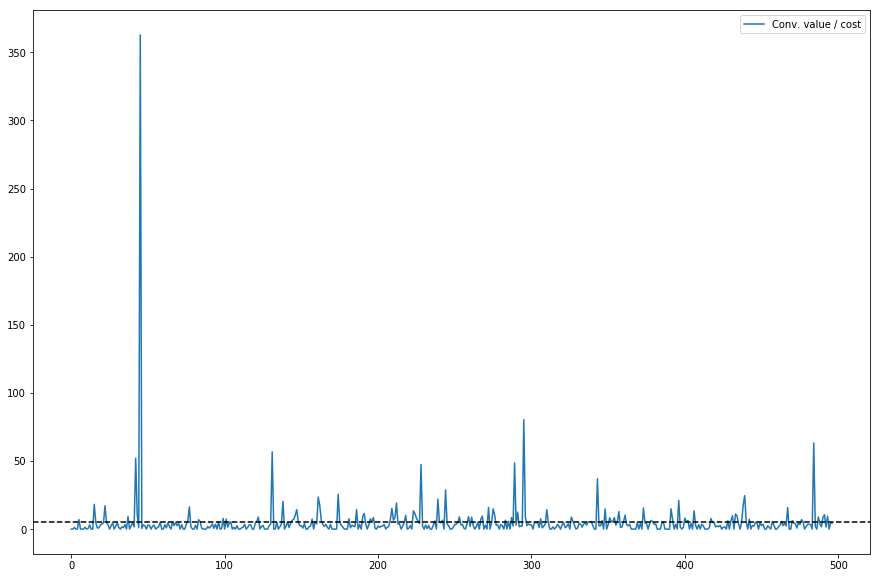

In [9]:
# This is the average revenue in $ per dollar spent on advertising.
# We should try to even out this graph, with ideally everything ~= 1 (thats for marginal though. Hmmmm)
# So press down the bumps with an increase in spending, and pull up the troughs by decreasing spending.

mobile[["Conv. value / cost"]].plot().axhline(y=mobile["Conv. value / cost"].describe().iloc[1], color='black', linestyle='--')

In [10]:
# orig_mobile

In [11]:
# TODO

#Split df into state and city/zip adjustments


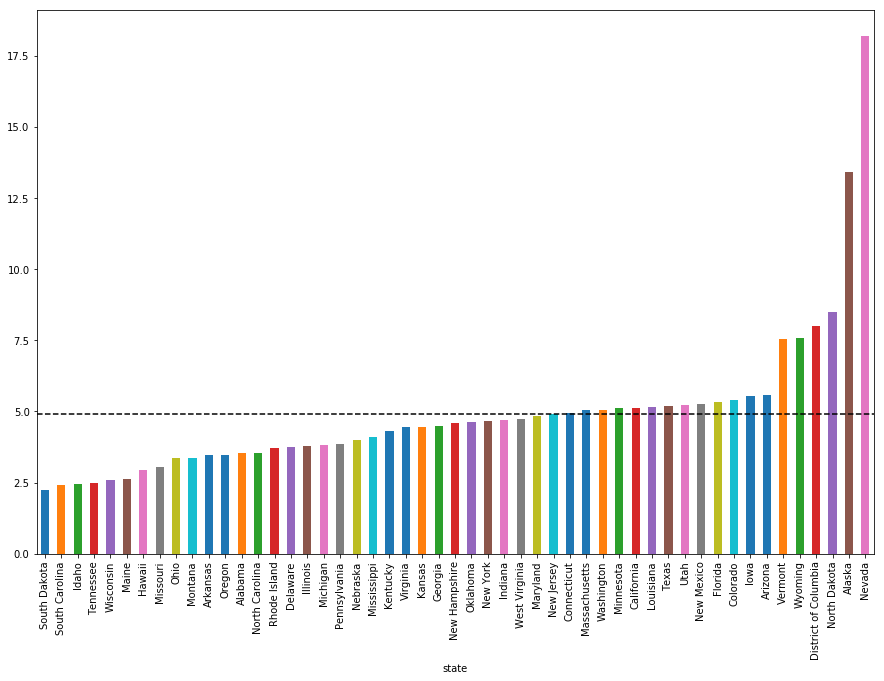

In [12]:
# Examining State Level Bid Adjustments
# Plot - Conv. Value / Cost


state_adjustments = mobile[mobile.cityzip.isna()]
state_adjustments = state_adjustments[~state_adjustments.state.isna()]
state_adjustments = state_adjustments.set_index('state')
state_adjustments = state_adjustments.sort_values('Conv. value / cost')
state_adjustments['Conv. value / cost'].plot.bar().axhline(y=state_adjustments["Conv. value / cost"].describe().iloc[1], color='black', linestyle='--')


In [13]:
# This gives us 2 issues to examine - wether we are underbidding at the tail (right),
# and/or overbidding at the head (left)

In [14]:
# Underbidding at right

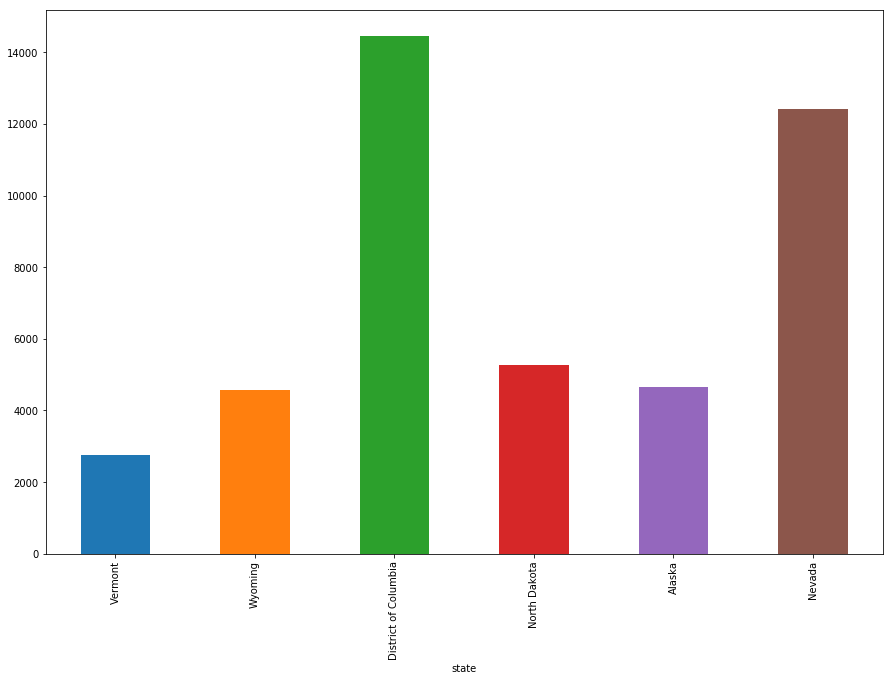

In [15]:
state_adjustments.tail(6)['Conv. value($)'].plot.bar()

In [16]:
state_adjustments.tail(6)

,Location,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost,cityzip
state,,,,,,,,,,,,,,
Vermont,"Vermont, United States",-15.0,1229.0,17899.0,6.87,0.30,364.60,3.0,28.0,13.02,2.28,2751.68,7.55,NaN
Wyoming,"Wyoming, United States",30.0,1653.0,22872.0,7.23,0.37,604.75,3.0,47.0,12.83,2.85,4563.33,7.57,NaN
District of Columbia,"District of Columbia, United States",45.0,4705.0,67808.0,6.94,0.38,1806.58,2.6,145.0,12.46,3.08,14450.32,8.00,NaN
North Dakota,"North Dakota, United States",0.0,1958.0,28348.0,6.91,0.32,620.38,3.0,47.0,13.20,2.40,5259.60,8.48,NaN
Alaska,"Alaska, United States",30.0,1041.0,14095.0,7.39,0.33,347.12,2.8,55.0,6.31,5.28,4656.91,13.42,NaN
Nevada,"Nevada, United States",0.0,2034.0,29739.0,6.84,0.34,683.25,2.8,115.0,5.94,5.66,12419.84,18.19,NaN


In [17]:
# In this graph, we're seeing only sales that came through state level BAs.
# Increase bids in NEVADA! 
# Also, given its relatively high Conv. Value, maybe a slight bump in DC maybe warranted as well.

In [18]:
# Overbidding?

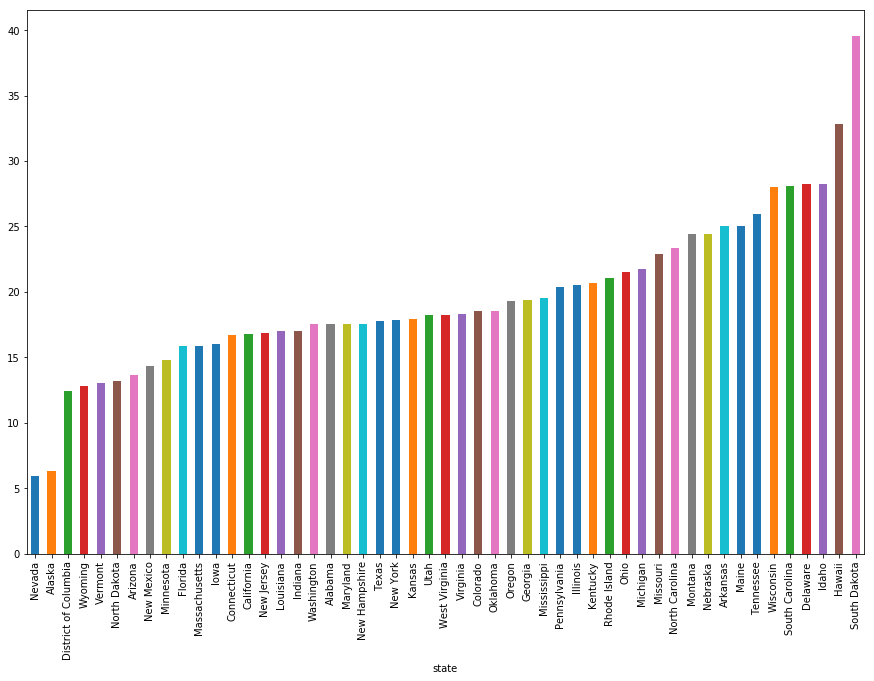

In [19]:
state_adjustments.sort_values('cost_per_conv($)')['cost_per_conv($)'].plot.bar()

In [20]:
state_adjustments.sort_values('cost_per_conv($)').tail()

,Location,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost,cityzip
state,,,,,,,,,,,,,,
South Carolina,"South Carolina, United States",15.0,10739.0,156711.0,6.85,0.32,3452.93,2.9,123.0,28.07,1.15,8333.30,2.41,NaN
Delaware,"Delaware, United States",-15.0,1602.0,23925.0,6.70,0.32,509.67,3.0,18.0,28.27,1.13,1920.44,3.77,NaN
Idaho,"Idaho, United States",-45.0,1768.0,29897.0,5.91,0.26,452.33,3.1,16.0,28.27,0.90,1104.88,2.44,NaN
Hawaii,"Hawaii, United States",45.0,2741.0,32963.0,8.32,0.39,1082.58,2.7,33.0,32.81,1.20,3182.09,2.94,NaN
South Dakota,"South Dakota, United States",-15.0,1241.0,20665.0,6.01,0.25,316.30,3.1,8.0,39.54,0.64,711.99,2.25,NaN


In [21]:
# Is Hawai just competitive? CTR is higher, Conv Value/ Cost is actually lower than normal. 
# Maybe adjust down a bit? 

In [22]:
# S.D. is so small that making changes probably won't affect things. But still maybe we can make it a bit lower.

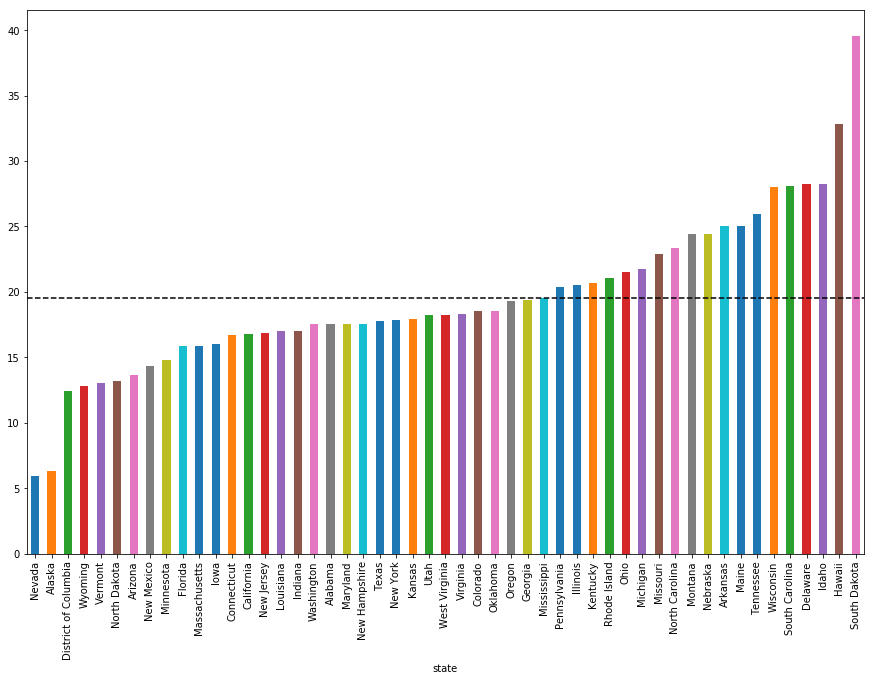

In [23]:
state_adjustments = state_adjustments.sort_values('cost_per_conv($)')
state_adjustments['cost_per_conv($)'].plot.bar().axhline(y=state_adjustments["cost_per_conv($)"].describe().iloc[1], color='black', linestyle='--')


In [24]:
# Moving on to City / Zip Code adjustments

In [25]:
# For City Adjustments

,Location,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost,state
cityzip,,,,,,,,,,,,,,
Lakeland,"Lakeland, Tennessee, United States",60.0,138.0,1631.0,8.46,0.45,61.68,2.6,10.0,6.17,7.25,1253.83,20.33,Tennessee
Anchorage,"Anchorage, Alaska, United States",10.0,917.0,13179.0,6.96,0.33,303.87,2.8,46.0,6.61,5.02,6654.07,21.90,Alaska
Fitchburg,"Fitchburg, Massachusetts, United States",60.0,114.0,1497.0,7.62,0.47,53.14,2.6,6.0,8.86,5.26,1248.73,23.50,Massachusetts
Irving,"Irving, Texas, United States",-30.0,222.0,3238.0,6.86,0.20,44.13,3.3,11.0,4.01,4.95,1082.98,24.54,Texas
Billerica,"Billerica, Massachusetts, United States",60.0,105.0,1366.0,7.69,0.44,46.65,2.5,11.0,4.24,10.48,1191.84,25.55,Massachusetts
Riverside,"Riverside, California, United States",-45.0,163.0,3616.0,4.51,0.17,27.29,3.3,4.0,6.82,2.45,786.34,28.81,California
Calera,"Calera, Alabama, United States",60.0,54.0,715.0,7.55,0.41,22.37,2.6,5.0,4.47,9.26,1060.98,47.43,Alabama
Chandler,"Chandler, Arizona, United States",-30.0,212.0,4002.0,5.30,0.21,43.88,3.1,8.0,5.49,3.77,2134.66,48.65,Arizona
Swansboro,"Swansboro, North Carolina, United States",60.0,52.0,620.0,8.39,0.43,22.28,2.5,14.0,1.59,26.92,1409.66,63.27,North Carolina


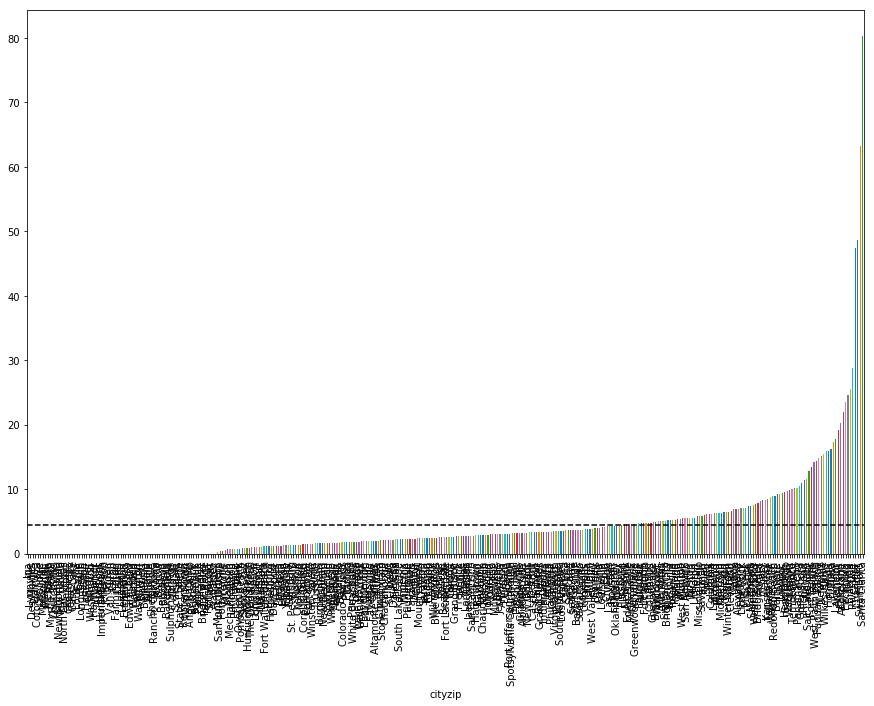

In [26]:
city_adjustments = mobile[~mobile.cityzip.isna()].sort_values('cityzip').tail(441-97)
city_adjustments = city_adjustments.set_index('cityzip')
city_adjustments= city_adjustments.sort_values('Conv. value / cost')
city_adjustments['Conv. value / cost'].plot.bar().axhline(y=city_adjustments["Conv. value / cost"].describe().iloc[1], color='black', linestyle='--')
city_adjustments.tail(10)

In [27]:
city_adjustments

,Location,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost,state
cityzip,,,,,,,,,,,,,,
Ina,"Ina, Illinois, United States",60.0,3.0,54.0,5.56,0.33,0.98,2.3,0.0,0.00,0.00,0.00,0.00,Illinois
Lynnville,"Lynnville, Tennessee, United States",60.0,4.0,84.0,4.76,0.32,1.26,2.5,0.0,0.00,0.00,0.00,0.00,Tennessee
Des Moines,"Des Moines, Iowa, United States",-60.0,122.0,2701.0,4.52,0.10,12.38,3.4,0.0,0.00,0.00,0.00,0.00,Iowa
Danville,"Danville, West Virginia, United States",60.0,9.0,144.0,6.25,0.38,3.40,2.9,0.0,0.00,0.00,0.00,0.00,West Virginia
Coto de Caza,"Coto de Caza, California, United States",60.0,77.0,1033.0,7.45,0.50,38.75,2.5,0.0,0.00,0.00,0.00,0.00,California
Coolidge,"Coolidge, Arizona, United States",60.0,33.0,435.0,7.59,0.42,13.77,2.5,0.0,0.00,0.00,0.00,0.00,Arizona
Melbourne,"Melbourne, Florida, United States",-60.0,90.0,2516.0,3.58,0.13,12.03,3.3,0.0,0.00,0.00,0.00,0.00,Florida
Meredith,"Meredith, New Hampshire, United States",60.0,13.0,257.0,5.06,0.28,3.61,2.7,0.0,0.00,0.00,0.00,0.00,New Hampshire
Mesquite,"Mesquite, Nevada, United States",60.0,37.0,468.0,7.91,0.37,13.66,2.6,0.0,0.00,0.00,0.00,0.00,Nevada


In [41]:
# ZIP Adjustments

In [ ]:
# Cant we just take the top whatever number of zip adjustments we have now zip codes by income level and throw
# in filters?

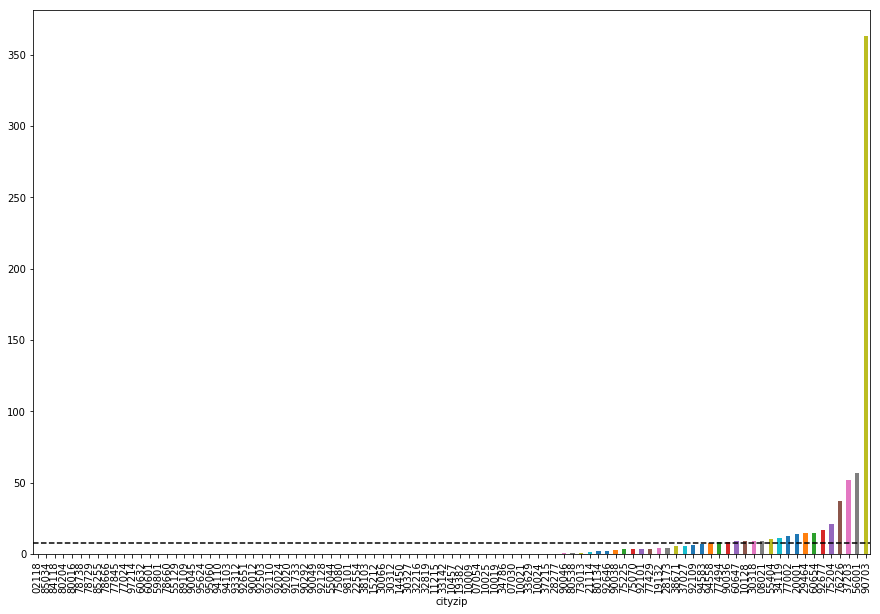

In [44]:
zip_adjustments = mobile[~mobile.cityzip.isna()].sort_values('cityzip').head(97)
zip_adjustments = zip_adjustments.set_index('cityzip')
zip_adjustments = zip_adjustments.sort_values('Conv. value / cost')


# state_adjustments['Conv. value / cost'].plot.bar().axhline(y=state_adjustments["Conv. value / cost"].describe().iloc[1], color='black', linestyle='--')

zip_adjustments['Conv. value / cost'].plot.bar().axhline(y=zip_adjustments["Conv. value / cost"].describe().iloc[1], color='black', linestyle='--')
# zip_adjustments.tail(10)

In [49]:
# zip_adjustments[zip_adjustments['Conv. value / cost']>50]
zip_adjustments.tail(15)

,Location,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost,state
cityzip,,,,,,,,,,,,,,
10128,"10128, New York, United States",45.0,47.0,619.0,7.59,0.50,23.41,2.9,3.0,7.80,6.38,206.42,8.82,New York
30318,"30318, Georgia, United States",-40.0,439.0,8865.0,4.95,0.17,75.58,3.2,8.0,9.42,1.83,680.38,9.03,Georgia
08021,"08021, New Jersey, United States",45.0,114.0,1534.0,7.43,0.42,47.67,2.8,6.0,7.95,5.26,438.40,9.20,New Jersey
55404,"55404, Minnesota, United States",-60.0,79.0,1983.0,3.98,0.09,7.44,3.5,2.0,3.72,2.53,75.98,10.21,Minnesota
34119,"34119, Florida, United States",45.0,36.0,688.0,5.23,0.40,14.31,2.8,2.0,7.16,5.56,159.05,11.11,Florida
77002,"77002, Texas, United States",-60.0,56.0,1611.0,3.48,0.09,5.11,3.3,1.0,5.11,1.79,63.59,12.44,Texas
20001,"20001, District of Columbia, United States",-80.0,130.0,4027.0,3.23,0.05,6.39,3.6,2.0,3.20,1.54,91.21,14.27,District of Columbia
29464,"29464, South Carolina, United States",36.0,168.0,1979.0,8.49,0.40,66.65,2.7,4.0,16.66,2.38,985.49,14.79,South Carolina
60654,"60654, Illinois, United States",45.0,62.0,846.0,7.33,0.42,26.16,2.6,3.0,8.72,4.84,389.30,14.88,Illinois


In [9]:
# TODO

# Find a list of places where this graph is spiking, and graph against number of coversions
# We should try to figure out how many are unique conversions/ as opposed to a returning customers.


In [10]:
mobile[mobile["Conv. value / cost"]>3]

,Location,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost,state,cityzip
0,"Milwaukee, Wisconsin, United States",60.0,482.0,9312.0,5.18,0.67,324.67,2.5,21.0,15.46,4.36,1900.95,5.86,Wisconsin,Milwaukee
1,"Plant City, Florida, United States",30.0,57.0,632.0,9.02,0.69,39.38,2.7,5.0,7.88,8.77,491.92,12.49,Florida,Plant City
2,"North Carolina, United States",0.0,6205.0,102295.0,6.07,0.50,3076.82,2.8,131.0,23.49,2.11,11291.79,3.67,North Carolina,NaN
7,"San Jose, California, United States",30.0,892.0,17326.0,5.15,0.58,513.73,2.7,34.0,15.11,3.81,3989.49,7.77,California,San Jose
9,"Ellicott City, Maryland, United States",60.0,95.0,1622.0,5.86,0.74,69.84,2.5,1.0,69.84,1.05,210.04,3.01,Maryland,Ellicott City
10,"Conroe, Texas, United States",60.0,150.0,2192.0,6.84,0.70,104.90,2.6,4.0,26.23,2.67,798.86,7.62,Texas,Conroe
13,"Utah, United States",0.0,2663.0,38312.0,6.95,0.55,1462.09,2.5,69.0,20.93,2.62,7814.38,5.41,Utah,NaN
18,"Spring, Texas, United States",15.0,249.0,4146.0,6.01,0.54,133.79,2.8,7.0,19.11,2.81,672.82,5.03,Texas,Spring
22,"Salt Lake City, Utah, United States",0.0,377.0,6673.0,5.65,0.47,177.75,2.6,12.0,14.65,3.20,1239.55,7.05,Utah,Salt Lake City
23,"Killeen, Texas, United States",60.0,136.0,2094.0,6.49,0.78,105.82,2.5,3.0,35.20,2.22,624.36,5.91,Texas,Killeen


In [11]:
# TODO - See if there is a mismatch between adjustment and cost/conv. if there is a positive BA
# but low conversions OR high cost/conversion(?) we should revise downwards



In [12]:
# TODO - Separate state level bids and compare them to agregated bids by city per state. If there is a mismatch,
# Lets say we have a BA of +50% in the state but in the cities and zips we have -50, that doesn't make sense.

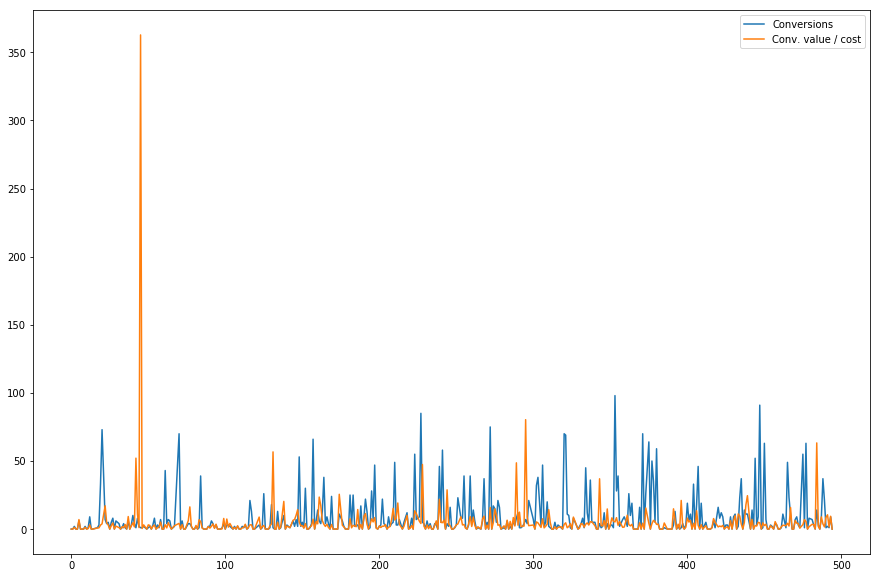

In [45]:
df2 = mobile[mobile['Conversions']<100]
df2[["Conversions","Conv. value / cost"]].plot()

In [14]:
# Sort this by column1
mobile["Conv. value / cost"].value_counts().head()

0.00    96
0.94     4
0.35     3
2.57     3
4.39     3
Name: Conv. value / cost, dtype: int64

In [15]:
# There are a number of records where no conversions happen, and some of them cost a lot of money
# We could turn down the BA on these.
# Is there anything we need to check against for this? 
# The conversion rate here is 0
# Total cost for these ads - once the cost is an int.

cost_where_no_conversion= 0
